In [1]:
import pickle
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from MARBLE import utils, postprocessing,plotting,geometry
import gc


# --- Configuration ---
dataset_name="marble_bandpower_b10_c10"
dataset_path = f'Datasets/MARBLE/{dataset_name}_dataset.pkl'
model_path = f'models/{dataset_name}_model.pkl'  # Model path with similar name
plot_dir = 'Figures'  # Directory to save the confusion matrix plot
os.makedirs(plot_dir, exist_ok=True)
device= 'cuda'

# --- Load Dataset and Model ---
print(f"Loading dataset from {dataset_path}...")
with open(dataset_path, 'rb') as f:
    Marble_Dataset = pickle.load(f)
print(f"Dataset loaded from {dataset_path}")

print(f"Loading model from {model_path}...")
with open(model_path, 'rb') as f:
    model = pickle.load(f)
print(f"Model loaded from {model_path}")

if device == 'cuda':
    # --- Transform on CPU ---
    print("Computing embeddings on CUDA...")
    model.device = torch.device('cuda')
    model.to('cuda')
    Marble_Dataset.to('cuda')
    transformed_Dataset = model.transform(Marble_Dataset)
    transformed_Dataset = postprocessing.distribution_distances(transformed_Dataset, n_clusters=5)
    transformed_Dataset = postprocessing.embed_in_2D(transformed_Dataset)
else:
    # --- Transform on CPU ---
    print("Computing embeddings on CPU...")
    model.device = torch.device('cpu')
    model.to('cpu')
    Marble_Dataset.to('cpu')
    # Transform on CPU
    with torch.no_grad():
        size = (Marble_Dataset.x.shape[0], Marble_Dataset.x.shape[0])
        adjs = utils.EdgeIndex(Marble_Dataset.edge_index, torch.arange(Marble_Dataset.edge_index.shape[1]), size)
        adjs = utils.to_list(adjs) * model.params["order"]
        
        try:
            Marble_Dataset.kernels = [
                utils.to_SparseTensor(K.coalesce().indices(), value=K.coalesce().values()).t()
                for K in utils.to_list(Marble_Dataset.kernels)
            ]
        except Exception:
            pass
        
        out, _ = model.forward(Marble_Dataset, torch.arange(len(Marble_Dataset.x)), adjs)
        Marble_Dataset.emb = out.detach()

    transformed_Dataset = Marble_Dataset
    transformed_Dataset = postprocessing.distribution_distances(transformed_Dataset, n_clusters=5)
    transformed_Dataset = postprocessing.embed_in_2D(transformed_Dataset)

print("Embeddings computed.")
del Marble_Dataset
gc.collect()

Loading dataset from Datasets/MARBLE/marble_bandpower_b10_c10_dataset.pkl...
Dataset loaded from Datasets/MARBLE/marble_bandpower_b10_c10_dataset.pkl
Loading model from models/marble_bandpower_b10_c10_model.pkl...
Model loaded from models/marble_bandpower_b10_c10_model.pkl
Computing embeddings on CUDA...


/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.
Embeddings computed.


86680

<Figure size 800x800 with 0 Axes>

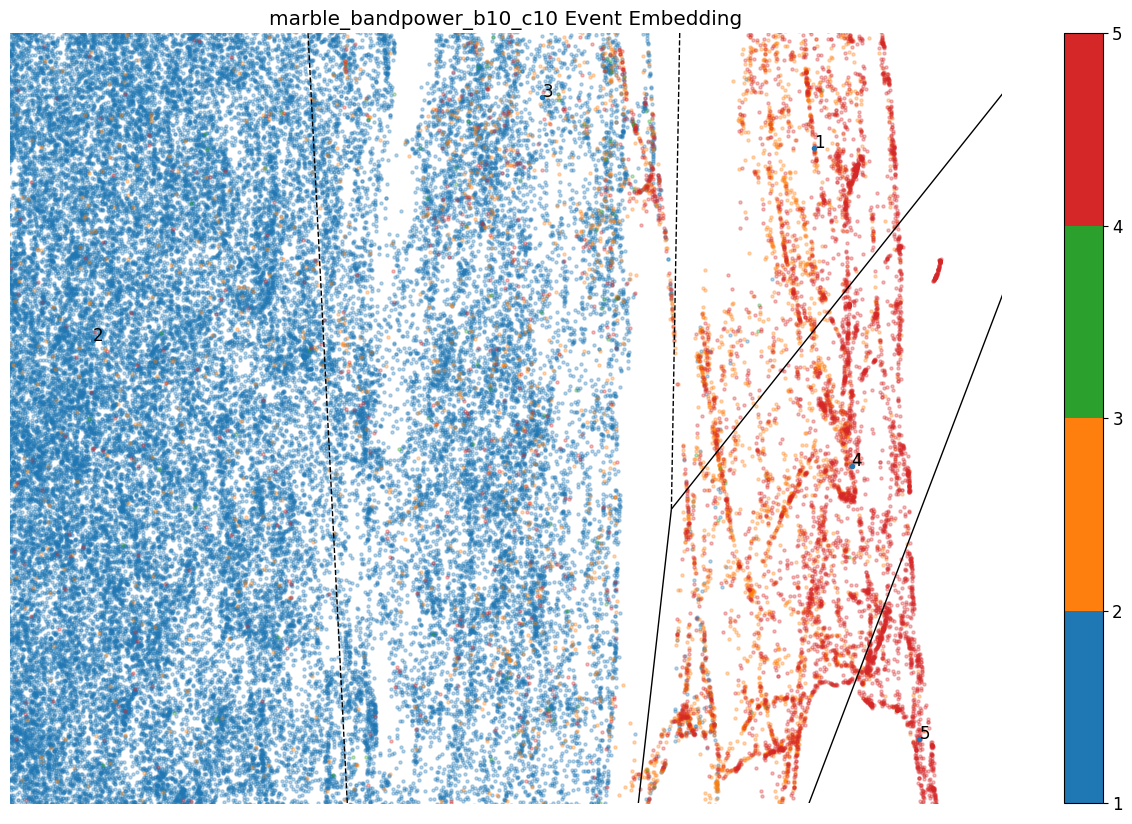

([], [])

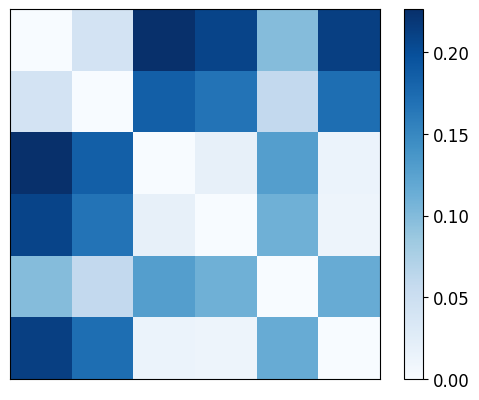

In [2]:
# Visualize embeddings
embeddings = transformed_Dataset.emb.cpu().numpy()
labels = transformed_Dataset.label.cpu().numpy().flatten().astype(int)

# Set display parameters
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

plt.figure(figsize=(8, 8))
ax = plotting.embedding(
    transformed_Dataset, 
    labels,
    clusters_visible=True)
plt.title(f'{dataset_name} Event Embedding')
plt.savefig(f'{plot_dir}/{dataset_name}_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 4.8))
im = plt.imshow(transformed_Dataset.dist, cmap='Blues')
plt.colorbar(im)
plt.xticks([])
plt.yticks([])

# # Plot different embeddings
# embed_types = ['PCA',  'umap']

# for embed_typ in embed_types:
#     emb, _ = geometry.embed(transformed_Dataset.dist, embed_typ=embed_typ)
#     plt.figure(figsize=(4, 4))
#     ax = plotting.embedding(emb, np.array(range(0,10)),s=30, alpha=1)
#     plt.title(f'{embed_typ} Embedding')
#     plt.savefig(f'{plot_dir}/{dataset_name}_dist_{embed_typ.lower()}.png', dpi=300, bbox_inches='tight')
#     plt.show()

# print("=" * 40)
# print(f"Results saved to {plot_dir}/ directory.")

In [3]:
# %% Import necessary libraries
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from decoder import train_evaluate_mlp, train_evaluate_logistic_regression, train_evaluate_svm

# %% Configuration
test_size = 0.3  # Fraction of data for testing
num_samples_to_use = None  # Use a subset for faster testing, set to None to use all
random_state = 42 # For reproducibility
decoder_type = "mlp"  # Options: "mlp", "logistic_regression", "svm"

embeddings = transformed_Dataset.emb_2D
print(f"Original Embeddings shape: {embeddings.shape}, Labels shape: {labels.shape}")

# Limit the number of samples if specified
if num_samples_to_use is not None and num_samples_to_use < len(embeddings):
    print(f"Selecting {num_samples_to_use} random samples.")
    indices = np.random.choice(len(embeddings), num_samples_to_use, replace=False)
    embeddings_subset = embeddings[indices]
    labels_subset = labels[indices]
else:
    print("Using all available samples.")
    embeddings_subset = embeddings
    labels_subset = labels

print(f"Using {len(embeddings_subset)} samples for training and testing")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_subset, labels_subset,
    test_size=test_size,
    random_state=random_state,
    stratify=labels_subset # Stratify if labels are imbalanced
)

print("--- Running Decoder ---")
# Common parameters
input_dim = X_train.shape[1]
output_dim = len(np.unique(labels_subset)) # Use unique labels from the subset

# Choose and run decoder based on decoder_type
if decoder_type == "mlp":
    print("\n--- Training MLP Decoder ---")
    accuracy, report, y_pred = train_evaluate_mlp(
        X_train, y_train, X_test, y_test,
        input_dim=input_dim,
        output_dim=output_dim,
        num_epochs=10 # Adjust epochs as needed
    )
    decoder_name = "MLP"
elif decoder_type == "logistic_regression":
    print("\n--- Training Logistic Regression Decoder ---")
    accuracy, report, y_pred = train_evaluate_logistic_regression(
        X_train, y_train, X_test, y_test
    )
    decoder_name = "Logistic Regression"
elif decoder_type == "svm":
    print("\n--- Training SVM Decoder (RBF Kernel) ---")
    accuracy, report, y_pred = train_evaluate_svm(
        X_train, y_train, X_test, y_test,
        kernel='rbf' # Example non-linear kernel
    )
    decoder_name = "SVM (RBF)"
else:
    raise ValueError(f"Unknown decoder type: {decoder_type}")

# Print results
print("-" * 20)
print(f"{decoder_name} Accuracy: {accuracy:.4f}")
print("-" * 20)
print(report)
print("-" * 20)
print("Decoding script finished.")

# Plot confusion matrix for the selected decoder
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true labels)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Normalized Confusion Matrix for {decoder_name} Classification')
plt.tight_layout()


Original Embeddings shape: (238414, 2), Labels shape: (238414,)
Using all available samples.
Using 238414 samples for training and testing
--- Running Decoder ---

--- Training MLP Decoder ---
MLP using device: cuda


MLP Epoch 1/10, Loss: 0.2134
MLP Epoch 2/10, Loss: 0.1748
MLP Epoch 3/10, Loss: 0.1718
MLP Epoch 4/10, Loss: 0.1697
MLP Epoch 5/10, Loss: 0.1689
MLP Epoch 6/10, Loss: 0.1678
MLP Epoch 7/10, Loss: 0.1670
MLP Epoch 8/10, Loss: 0.1666
MLP Epoch 9/10, Loss: 0.1663
MLP Epoch 10/10, Loss: 0.1659


/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

MLP Accuracy: 0.9522
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     65923
           1       0.60      0.31      0.40      2932
           2       0.00      0.00      0.00       101
           3       0.70      0.56      0.62      2569

    accuracy                           0.95     71525
   macro avg       0.57      0.47      0.50     71525
weighted avg       0.94      0.95      0.94     71525



ValueError: not enough values to unpack (expected 3, got 2)


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     65947
           1       0.58      0.25      0.35      2895
           2       0.00      0.00      0.00       103
           3       0.74      0.52      0.61      2580

    accuracy                           0.95     71525
   macro avg       0.57      0.44      0.49     71525
weighted avg       0.94      0.95      0.94     71525



/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

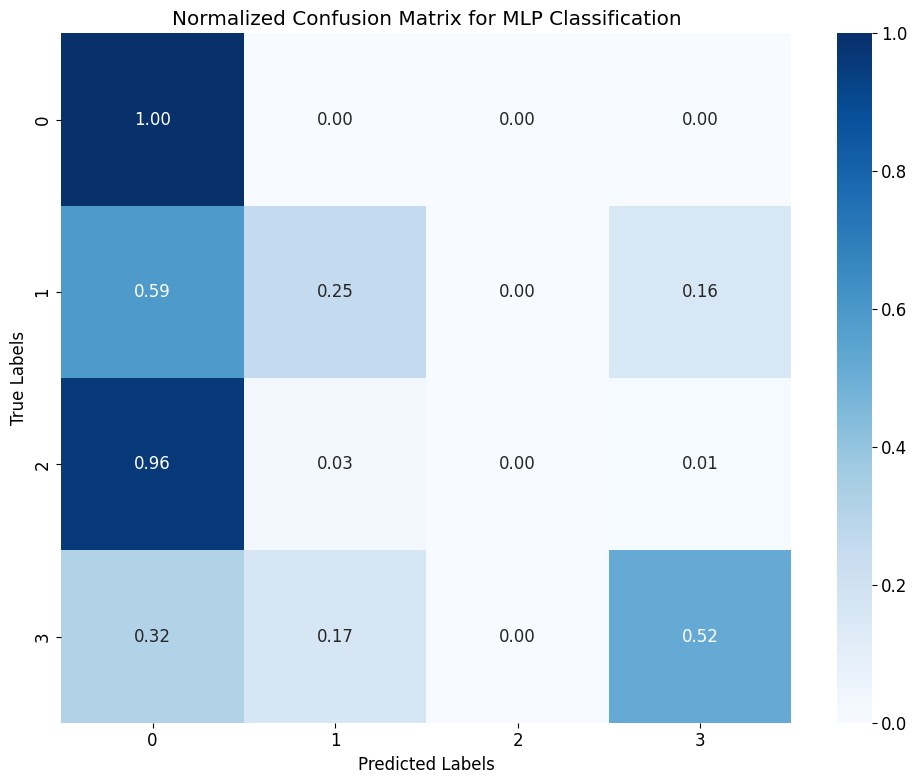